# In this work, only LoF mutations are used: calculate how many risk genes we can obtain with Nsample = 550

## Some ways have been used:

### Don't know any count information $=>$ use Poisson distribution

### Know counts from published data

### Use TADA method

### Use the trio package (for TDT)

I randomly chose 1000 genes, but it's probably better if choosing top 1000 genes from TADA results.

# Simulate counts from the Poisson distribution

## Some main steps:

nGene = Number of genes ( ~ 18500 genes)

. Randomly choose risk genes with prob = 1000/nGene

. Add relative risk into mutation rates of risk genes 

. Use Poisson distribution to sample all genes with new mutation rates

. Use Poisson test to obtain p values:

    At the $i^{th}$ gene, $p_value = P(X >= x_i| lambda = 2*Nsample*mu_i)$
 
 . Count genes with pvalues < 0.05
 
 Didn't adjust for all tests, with Nsample = 550: it's difficult to obtain significant values after adjustment


In [3]:
data <- read.csv("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
mu <- data$mut.rate
mu.frac <- c(0.074, 0.32)
pi <- 0.06
gamma.mean <- c(18, 5.4)
beta <- c(1, 0.5)
gamma.mean.est <- c(18, 5.4)
beta.est <- c(1, 0.5)

Nsample <- 550
mutLoF0 <- data$mut.rate*mu.frac[1] #(mu.frac[1]) # + mu.frac[2]) ##Mutation rates
nGene <- length(mutLoF0)

message("nGene: ", nGene)

Ntimes <- 100 ##Do this work Ntimes
geneCountforPower2 <- NULL
for (k in 1:Ntimes) {

rrList <- seq(1, 30, by = 1)
finalResult <- matrix(0, ncol = length(rrList), nrow = nGene)
##Add relative risks to risk genes
piRG <- 1000/nGene ##Proportion of risk genes
z <- rbinom(nGene, 1, piRG)
table(z)/nGene
    
for (ii in 1:length(rrList)){
  RR <- rrList[ii]

  mutLoF <- mutLoF0
  
  mutLoF[z==1] <- mutLoF[z==1]*RR ##*rgamma(mutLoF[z==1], RR, rate = 1)
  geneCount <- rpois(nGene, 2*mutLoF*Nsample)

  
  
  poissonTest <- ppois(geneCount - 1, lambda = 2*Nsample*mutLoF0, lower.tail = FALSE)
  
  finalResult[, ii] <- poissonTest
}

#apply(finalResult, 2, range)
t1 <- apply(finalResult, 2, function(x) length(x[x < 0.05]))

geneCountforPower2 <- rbind(geneCountforPower2, t1)
}

gCount <- ceiling(apply(geneCountforPower2, 2, median))
            
            


nGene: 18735


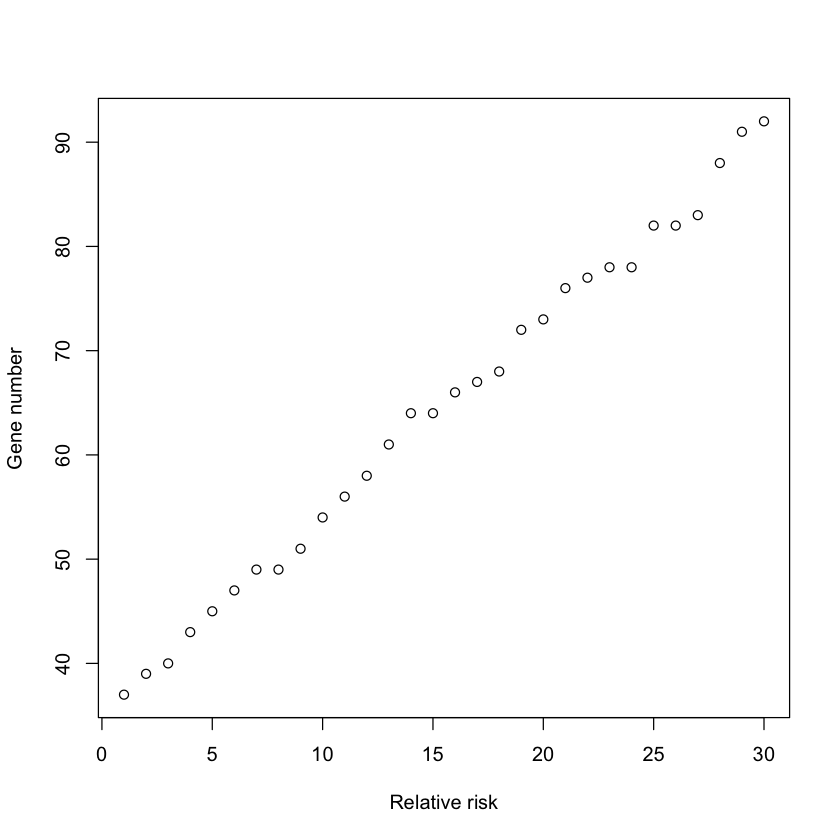

In [4]:
gCount <- ceiling(apply(geneCountforPower2, 2, median))

plot(rrList, gCount, xlab = 'Relative risk', ylab = 'Gene number')

# Use real counts from published data

## A little bit messy below, and not the results we want

## Use the data of AUT + EPI

Take a quick look all information

#### DISEASE	NUM_INDIV

AUT	3985

CHD	362

EPI	356

ID	192

SCZ	1024

SIB_CONTROL	2049

### wc -l AUT+EPI.LoF.mut 

  637

(3985 AUT + 356 EPI) samples have 637 LoF mutations

#### Here, I randomly allocate counts to nGene, but counts should be allocated to the top 1000 genes


In [5]:
sum(data$dn.LoF)

[1] 308

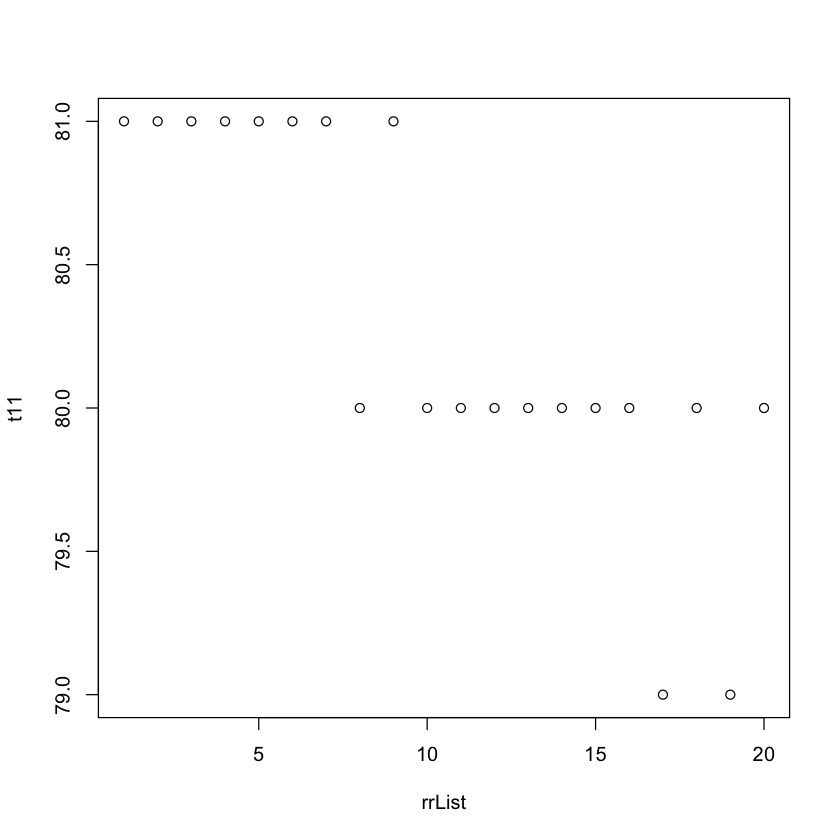

In [6]:
Nsample_old <- 3985 + 356 ##There are 637 de novo mutations in this sample set
Nsample <- 550
Ncount_old <- 637
nDenovo <- ceiling(Nsample*Ncount_old/Nsample_old )

mutLoF0 <- data$mut.rate*(mu.frac[1]) # + mu.frac[2]) ##Mutation rates
nGene <- length(mutLoF)

geneCountforPower1 <- NULL
Ntimes <- 10 ##Do this work Ntimes

for (kk in 1:Ntimes) {
  
indexRiskGene <- sample(1:nGene, 1000) ##Choose nRiskGene = 1000 genes, using index


rrList <- seq(1, 20, by = 1) ## Range of relative risks
    
finalResult <- matrix(0, ncol = length(rrList), nrow = nGene)

    ##Add relative risks to risk genes
for (ii in 1:length(rrList)){
      RR <- rrList[ii]
      mutLoF <- mutLoF0
       mutLoF[indexRiskGene] <- mutLoF[indexRiskGene]*RR

    nMutLoF <- mutLoF/sum(mutLoF) ##Normalize mutation rates to 1
    sum(nMutLoF)

##Randomly assign each de novo mutation (from nDenovo) to a gene with probabilies = normalized mutation rates
sDenovo <- table(sapply(1:nDenovo, function(x)
    sample(1:nGene, 1, prob = nMutLoF)))

sum(sDenovo)
geneCount <- numeric(nGene)
geneCount[as.numeric(names(sDenovo))] <- sDenovo ##Assign counts to specific genes


poissonTest <- ppois(geneCount - 1, lambda = 2*Nsample*mutLoF0, lower.tail = FALSE)

finalResult[, ii] <- poissonTest
}

apply(finalResult, 2, range)
t10 <- apply(finalResult, 2, function(x) length(x[x < 0.05]))
geneCountforPower1 <- rbind(geneCountforPower1, t10)
}

t11 <- ceiling(apply(geneCountforPower1, 2, mean))
plot(rrList, t11)

## TADA method

### Inside the TADA package, there is also a way to calculate gene numbers. We use this

In [ ]:
data <- read.csv("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
source("TADA/TADA.R")

mu <- data$mut.rate
mu.frac <- c(0.074, 0.32)
pi <- 0.06
gamma.mean.dn <- c(18, 5.4)
beta.dn <- c(1, 0.5)
gamma.mean.CC <- c(2.3, 1.0)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.66, 0.6)
nu1 <- c(1947, 123)
rho0 <- c(0.66, 0.64)
nu0 <- c(1947, 123)
rho1.est <- c(0.1, 0.5)
nu1.est <- c(200, 100)
rho0.est <- c(0.1, 0.5)
nu0.est <- c(200, 100)
hyperpar.est <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1.est, nu1.est, rho0.est, nu0.est))


nr <- 10
rs <- numeric(nr)
N <- c(550, 1000, 5000) #1000*seq(0.5, 5, by = 0.5)
power.mean <- numeric(length(N))
power.sd <- numeric(length(N))
for (i in 1:length(N)) {
  N.curr <- list(dn=N[i], ca=N[i], cn=N[i])
  rs <- replicate(nr, eval.TADA(N.curr, mu, mu.frac, pi, gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0, hyperpar.est, FDR=0.1, tradeoff=TRUE)$M1)
  power.mean[i] <- mean(rs)
  power.sd[i] <- sd(rs)
}
power <- data.frame(mean=power.mean, sd=power.sd)

powerAll <- power
plot(N, powerAll$mean, type = 'both')


# Use the trio package from the Bioconductor project

In [7]:
library("trio")

trio.power(maf = c(0.005), RR = 18.3, beta = 0.8, model = c("add", "dom"))


       Trio studies sample size calculation 

   Test          Model   MAF alpha   RR beta Trios
1  gTDT       additive 0.005 5e-08 18.3  0.8   481
2  gTDT       dominant 0.005 5e-08 18.3  0.8   500
3 Score       additive 0.005 5e-08 18.3  0.8   273
4 Score       dominant 0.005 5e-08 18.3  0.8   273
5  aTDT multiplicative 0.005 5e-08 18.3  0.8   273